In [2]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xlrd
import openpyxl
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import math
import _pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap

In [3]:
with open("pkls/r6_pq.pkl", "rb") as f:
    a = _pickle.load(f)
with open("pkls/list_item.pkl", "rb") as f:
    list_item = _pickle.load(f)
with open("pkls/m3_list.pkl", "rb") as f:
    m3_list = _pickle.load(f)
with open('pkls/df_m3_item.pkl', 'rb') as f:
    df_m3_item_p = _pickle.load(f)
with open('pkls/df_sum_latlng.pkl', 'rb') as f:
    df_sum_latlng = _pickle.load(f)

matrix_kind_k = pd.read_csv('csvs/matrix_kind_k.csv', encoding='utf-16', index_col=0)
df = pd.read_csv("csvs/zansa.csv", names=["ts", "lat", "lng", "text"])
matrix_mesh_k = pd.read_csv("csvs/matrix_mesh_k.csv", encoding='utf-16', index_col=0)
k_item = pd.read_csv('csvs/matrix_kind_k.csv', encoding='utf-16', index_col=0)

In [26]:
with open('pkls/K_2_weights.pkl','rb') as f:
    k_2 = _pickle.load(f)
with open('pkls/k_1.pkl', 'rb') as f:
    k_1 = _pickle.load(f)

## 必要な関数と処理

In [4]:
# k_item_array = np.c_[list_item, a['Q'].T]
# k_item = pd.DataFrame(k_item_array, columns=['item',1,2,3,4,5,6])
# k_item.to_csv(path_or_buf='matrix_kind_k.csv', sep=',', encoding='utf_16')

In [5]:
k_item.columns

Index(['item', '1', '2', '3', '4', '5', '6'], dtype='object')

In [6]:
list(np.arange(13))
list_item
dict_item = dict(zip(list(np.arange(13)),list_item))

In [7]:
# df_sum = pd.concat([df_m3_item_p,pd.DataFrame(df_m3_item_p.sum(axis=1),columns=['total'])],axis=1)
# lat_list = np.array((matrix_mesh_k.lat, matrix_mesh_k.lng))
# df_sum_latlng = pd.concat([df_sum, pd.DataFrame(lat_list.transpose(), index=df_sum.index, columns=['lat', 'lng'])], axis=1)

In [8]:
# with open('pkls/df_sum_latlng.pkl', 'wb') as f:
#     _pickle.dump(df_sum_latlng, f)

In [9]:
# with open('pkls/df_sum.pkl', 'wb') as f:
#     _pickle.dump(df_sum, f)

In [10]:
df_sum_latlng['total_nor'] = df_sum_latlng['total'] / np.sum(np.array(df_sum_latlng['total']))

In [11]:
def mk_heatmap(df, hm=None, max_zoom=16, radius=30, blur=15, min_opacity=None): # Make a heatmap
    fujisawa = [35.37,139.47]
    center = fujisawa
    hmap = folium.Map(location=center, zoom_start=12)
    marker_list = []
    for i in range(len(df.index)):
        if hm == None:
            marker_latlng = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng']]
            input_list = marker_latlng
        else:
            marker_latlngx = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng'], df.loc[df.index.values[i], hm]]
            input_list = marker_latlngx
        marker_list.append(input_list)
    if hm == None:
        hmarker = HeatMap(marker_list)
    else:
        if min_opacity == None:
            hmarker = HeatMap(marker_list, max_zoom=max_zoom, radius=radius, blur=blur)
        else:    
            hmarker = HeatMap(marker_list, min_opacity=min_opacity, max_zoom=max_zoom, radius=radius, blur=blur)
    hmap.add_child(hmarker)
    return hmap

In [12]:
def plot_zansa2():
    center = [35.37,139.47]
    hmap = folium.Map(location=center, zoom_start=12)
    marker_list = []
    for i in range(len(df.index)):
    #         if hm == None:
        marker_latlng = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng']]
        input_list = marker_latlng
    #         else:
#         marker_latlngx = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng'], df.loc[df.index.values[i], 'total']]
#         input_list = marker_latlngx
        marker_list.append(input_list)
    #     if hm == None:
    hmarker = HeatMap(marker_list, max_zoom=1000,radius=13,blur=10)
    #     else:
    #         hmarker = HeatMap(marker_list, max_zoom=13, radius=40, blur=18)
#     hmarker = HeatMap(marker_list, max_zoom=13, radius=20, blur=30)
    hmap.add_child(hmarker)
    return hmap

In [13]:
def kind_num_bar(disp_dict=False):
#     plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
#     plt.rcParams["figure.figsize"] = [20, 12] # グラフのサイズを指定
#     plt.rcParams['font.size'] = 20 #フォントサイズを設定 default : 12
#     plt.rcParams['xtick.labelsize'] = 30 # 横軸のフォントサイズ
#     plt.rcParams['ytick.labelsize'] = 30 # 縦軸のフォントサイズ
    
    kind_num = np.array((385, 200, 1, 87, 86, 181, 38, 2, 3, 10, 37, 7, 3))
    kind_num_df = pd.concat([pd.DataFrame(np.array(range(13))), pd.DataFrame(list_item), pd.DataFrame(kind_num, columns=['total'])], axis=1)
    kind_num_df = kind_num_df.sort_values(by=['total'], ascending=False)
    kind_num_df = pd.DataFrame(np.array(kind_num_df), columns=['num', 'kind', 'total'])
    # plot
    x1 = kind_num_df.index
    y1 = kind_num_df['total']
    label = kind_num_df['kind']
    fig, ax = plt.subplots()
    plt.bar(x1, y1, tick_label=label)
    ax.set_xticklabels(label, rotation=300)
    plt.savefig('kind_num_bar3.eps', bbox_inches="tight")
    plt.show()
    if disp_dict == True:
        print(dict_item)

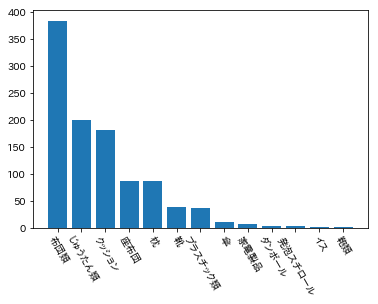

In [14]:
kind_num_bar()

In [15]:
kind_num = np.array((385, 200, 1, 87, 86, 181, 38, 2, 3, 10, 37, 7, 3))
matrix_kind_k['total'] = kind_num
matrix_kind_k_nor = pd.DataFrame(np.array(matrix_kind_k), columns=matrix_kind_k.columns)
lt130323 = list(matrix_kind_k_nor.columns)
lt130323.pop(0)
for i in lt130323:
    matrix_kind_k_nor[i] = matrix_kind_k_nor[i] / np.sum(np.array((matrix_kind_k_nor[i])))
matrix_kind_k_nor_dif = pd.DataFrame(np.array(matrix_kind_k_nor), columns=matrix_kind_k_nor.columns)
lt130323.pop(6)
for i in lt130323:
    matrix_kind_k_nor_dif[i] = matrix_kind_k_nor_dif[i] - matrix_kind_k_nor_dif['total']

In [16]:
def kind_dif_bar(df, str_k, disp_dict=False):
#     kind_num = np.array((385, 200, 1, 87, 86, 181, 38, 2, 3, 10, 37, 7, 3))
    df_col = list(df.columns)
    df_col.insert(0, 'num')
#     print(df_col)
    df = pd.concat([pd.DataFrame(np.array(range(13))), df], axis=1)
    df = df.sort_values(by=[str_k], ascending=False)
    df = pd.DataFrame(np.array(df), columns=df_col)
    # plot
    x1 = df.index
    y1 = df[str_k]
    label = df['num']
    plt.bar(x1, y1, tick_label=label)
    plt.show() 
    if disp_dict == True:
        print(dict_item)

In [17]:
matrix_kind_k_nor_dif

,item,1,2,3,4,5,6,total
0,布団類,-0.157572,-0.370192,0.0266251,0.0783311,-0.104218,-0.195719,0.370192
1,じゅうたん類,-0.167876,0.0469522,-0.147726,-0.192308,0.239314,-0.125291,0.192308
2,鞄類,-0.000961538,-0.000961538,-0.000774424,0.0290716,0.0196642,0.0198849,0.000961538
3,座布団,-0.0836538,0.0185348,-0.0583571,0.0714826,-0.0357755,0.175738,0.0836538
4,枕,0.337982,-0.0306178,-0.0496383,-0.0292263,-0.0812452,-0.0177756,0.0826923
5,クッション,-0.159528,0.191776,0.141222,-0.174038,-0.109767,-0.123233,0.174038
6,靴,0.101494,0.0179053,-0.0365385,0.149919,-0.0365385,0.000101432,0.0365385
7,イス,0.0313797,0.0386806,0.00774461,0.00373265,0.0283534,0.0389063,0.00192308
8,ダンボール,0.0230273,0.00519199,0.0496903,0.0413022,0.0149203,0.0107317,0.00288462
9,傘,0.025462,0.0232977,-0.00887587,0.027781,0.00615106,0.0274445,0.00961538


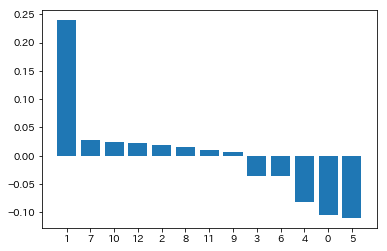

{0: '布団類', 1: 'じゅうたん類', 2: '鞄類', 3: '座布団', 4: '枕', 5: 'クッション', 6: '靴', 7: 'イス', 8: 'ダンボール', 9: '傘', 10: 'プラスチック類', 11: '家電製品', 12: '発泡スチロール'}


In [18]:
kind_dif_bar(matrix_kind_k_nor_dif, '5', 1)

In [19]:
def output_bar2(K,L=15):
    # item_k graph
    list_k = np.array((k_item[K]))
    array_item = np.array(list_item)
    tmp = np.c_[array_item, list_k]
    df_k = pd.DataFrame(tmp, columns=['item','k'])
    df_k = df_k.sort_values(by='k', ascending=False)
    list_1to12 = np.array(np.arange(len(k_item.index)))
    df_1to12 = pd.DataFrame(list_1to12, index=df_k.index, columns=['x_label'])
    df_k = pd.concat([df_k, df_1to12], axis=1)
    x1 = list(range(k_item.index.shape[0]))
    y1 = np.array(df_k['k'].tolist())
#     y1 = np.sort(y1)[::-1]

    # mesh_k graph
    df_1 = np.array(matrix_mesh_k[K])
    df_2 = list(map(str, list(matrix_mesh_k.index)))
    df_latlng = pd.DataFrame(np.array([matrix_mesh_k['lat'],matrix_mesh_k['lng']]).T, columns=['lat', 'lng'])
    df_12 = pd.DataFrame(df_1, columns=['k'])
    df_22 = pd.DataFrame(df_2, columns=['code'])
    num_list = list(np.arange(len(df_12)))
    df_3 = pd.concat([df_22, df_12, df_latlng], axis=1)
    df_3 = df_3.sort_values(by='k', ascending=False)
    df_4 = pd.DataFrame(num_list, index=df_3.index, columns=['index'])
    df_4 = pd.concat([df_3,df_4], axis=1)
    y2 = list(df_4['k'])
#     y2 = np.sort(y2)[::-1]
    x_label = list(df_4.index)
    for i in range(len(y2)-L):
        y2 = np.delete(y2, len(y2)-1)
        x_label = np.delete(x_label, len(x_label)-1)
    x2 = list(range(len(y2)))    
    
    # plot
#     plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
#     plt.rcParams["figure.figsize"] = [20, 12] # グラフのサイズを指定
#     plt.rcParams['font.size'] = 20 #フォントサイズを設定 default : 12
#     plt.rcParams['xtick.labelsize'] = 30 # 横軸のフォントサイズ
#     plt.rcParams['ytick.labelsize'] = 30 # 縦軸のフォントサイズ
    
#     hm_tmp = sns.heatmap(a["Q"],xticklabels=list_item, yticklabels=['1', '2', '3', '4', '5', '6'], cmap='Greys')
#     hm_tmp.set_xticklabels(list_item, rotation=60)
    
    print('kind-total')
    kind_num_bar()
    
    print('kind-k')
    fig, ax = plt.subplots()
    plt.bar(x1, y1, tick_label=df_k.index)
    ax.set_xticklabels(df_k['item'], rotation=300)
    fname1 = 'r' + str(K) + '_kind2.eps'
    print(fname1)
    plt.savefig(fname1, bbox_inches="tight")
    plt.show()
    
    print('kind-k-dif')
    kind_dif_bar(matrix_kind_k_nor_dif, K, 0)
    
    print(dict_item)#dict(zip(list(np.arange(len(x1))),list_item)))
    
    print('area-k')
    plt.bar(x2, y2, tick_label=x_label)
    plt.show()
    
    # heatmap
#     mk_heatmap(df_sum_latlng, 'total', 17, 27, 20, 0.2)
    
    fujisawa = [35.37,139.47]
    center = [35.37,139.55]
    hmap = folium.Map(location=center, zoom_start=12)
    marker_list = []
    df = df_4
    for i in range(len(y2)):
#         if hm == None:
#             marker_latlng = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng']]
#             input_list = marker_latlng
#         else:
        marker_latlngx = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng'], df.loc[df.index.values[i], 'k']]
        input_list = marker_latlngx
        marker_list.append(input_list)
#     if hm == None:
#         hmarker = HeatMap(marker_list)
#     else:
#         hmarker = HeatMap(marker_list, max_zoom=13, radius=40, blur=18)
    hmarker = HeatMap(marker_list, max_zoom=13, radius=40, blur=18)
    hmap.add_child(hmarker)
    return hmap
    
    print(df_4.head(15))
    

## 残渣の件数のヒートマップ 

In [20]:
plot_zansa2()

## 残渣の種類ごとの件数ヒートマップ 

In [21]:
mk_heatmap(df_sum_latlng, 'じゅうたん類')

In [22]:
mk_heatmap(df_sum_latlng, '布団類')

In [23]:
mk_heatmap(df_sum_latlng, 'クッション')

## kごとの残渣の種類の値とヒートマップ 

kind-total


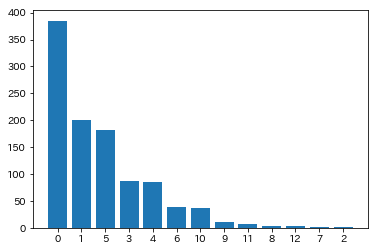

kind-k
r1_kind2.eps


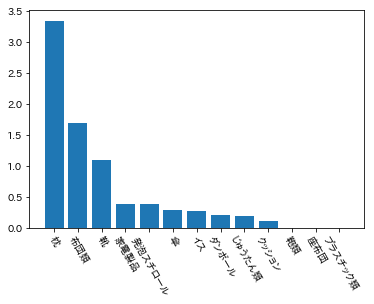

kind-k-dif


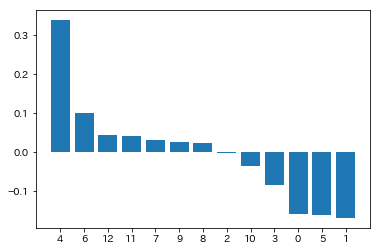

{0: '布団類', 1: 'じゅうたん類', 2: '鞄類', 3: '座布団', 4: '枕', 5: 'クッション', 6: '靴', 7: 'イス', 8: 'ダンボール', 9: '傘', 10: 'プラスチック類', 11: '家電製品', 12: '発泡スチロール'}
area-k


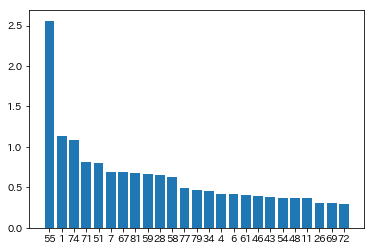

In [52]:
output_bar2('1', 25)

kind-total


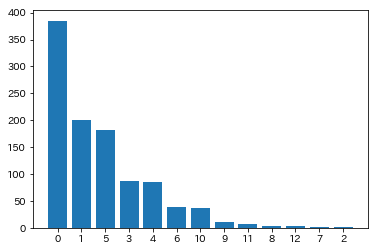

kind-k
r2_kind2.eps


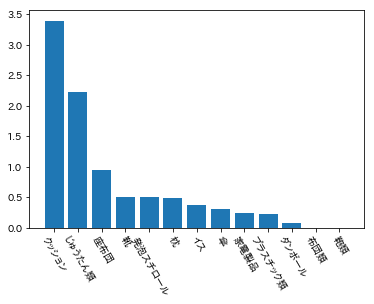

kind-k-dif


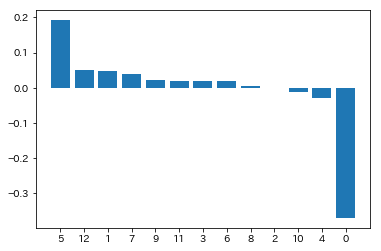

{0: '布団類', 1: 'じゅうたん類', 2: '鞄類', 3: '座布団', 4: '枕', 5: 'クッション', 6: '靴', 7: 'イス', 8: 'ダンボール', 9: '傘', 10: 'プラスチック類', 11: '家電製品', 12: '発泡スチロール'}
area-k


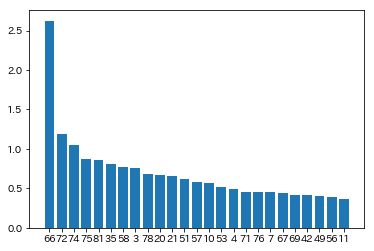

In [53]:
output_bar2('2', 25)

kind-total


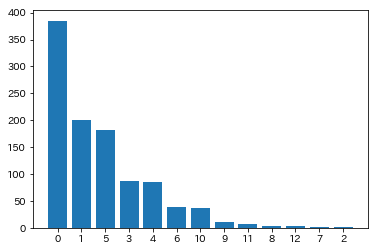

kind-k
r3_kind2.eps


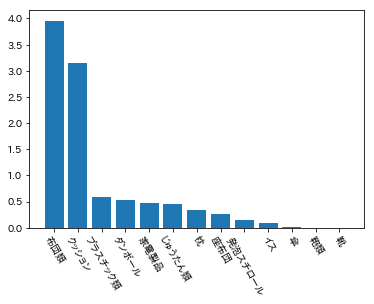

kind-k-dif


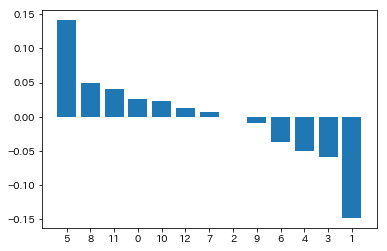

{0: '布団類', 1: 'じゅうたん類', 2: '鞄類', 3: '座布団', 4: '枕', 5: 'クッション', 6: '靴', 7: 'イス', 8: 'ダンボール', 9: '傘', 10: 'プラスチック類', 11: '家電製品', 12: '発泡スチロール'}
area-k


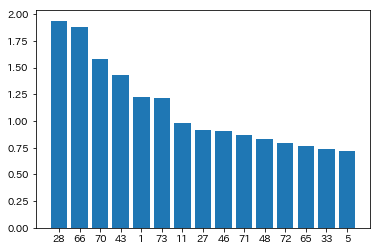

In [54]:
output_bar2('3', 15)

kind-total


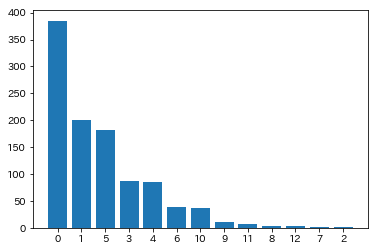

kind-k
r4_kind2.eps


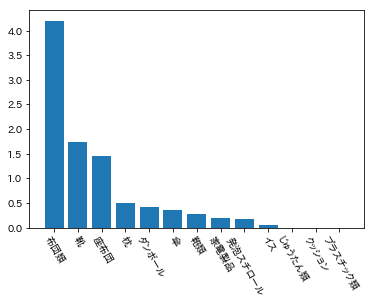

kind-k-dif


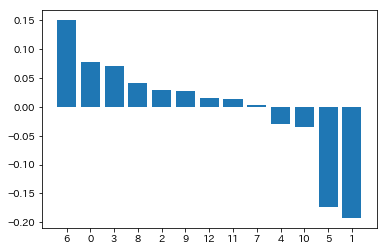

{0: '布団類', 1: 'じゅうたん類', 2: '鞄類', 3: '座布団', 4: '枕', 5: 'クッション', 6: '靴', 7: 'イス', 8: 'ダンボール', 9: '傘', 10: 'プラスチック類', 11: '家電製品', 12: '発泡スチロール'}
area-k


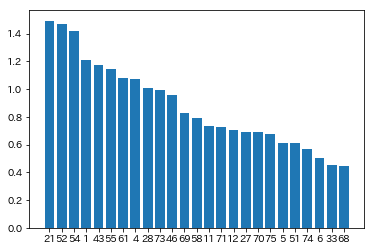

In [55]:
output_bar2('4', 25)

kind-total


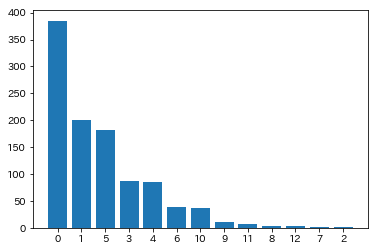

kind-k
r5_kind2.eps


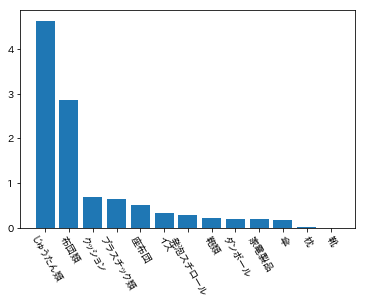

kind-k-dif


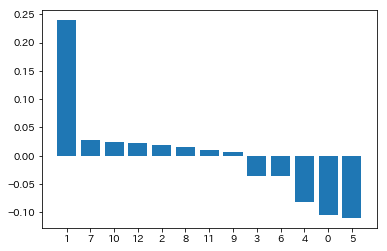

{0: '布団類', 1: 'じゅうたん類', 2: '鞄類', 3: '座布団', 4: '枕', 5: 'クッション', 6: '靴', 7: 'イス', 8: 'ダンボール', 9: '傘', 10: 'プラスチック類', 11: '家電製品', 12: '発泡スチロール'}
area-k


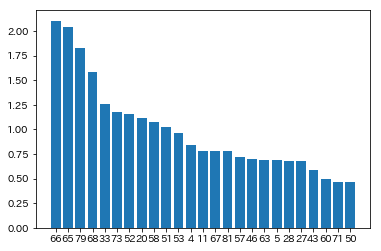

In [56]:
output_bar2('5', 25)

kind-total


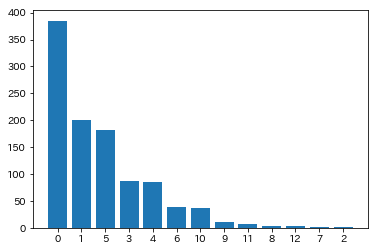

kind-k
r6_kind2.eps


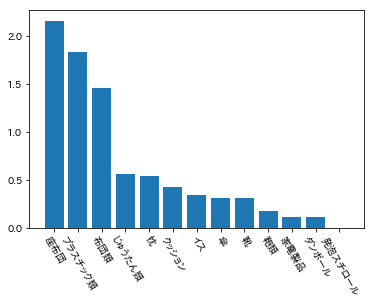

kind-k-dif


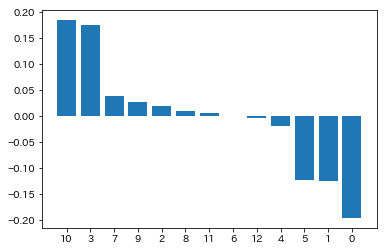

{0: '布団類', 1: 'じゅうたん類', 2: '鞄類', 3: '座布団', 4: '枕', 5: 'クッション', 6: '靴', 7: 'イス', 8: 'ダンボール', 9: '傘', 10: 'プラスチック類', 11: '家電製品', 12: '発泡スチロール'}
area-k


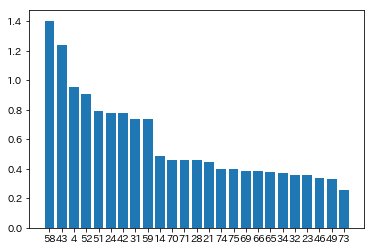

In [57]:
output_bar2('6', 25)